<h1>HW2 - Convolutional Neural Networks- Practical Q1_Part A</h1>
<h3><font color=yellow>Total Points: 100</font></h3>



<font color=greeen>Please, name this file as HW2_Q1_{Student_ID}.ipynb</font>

<h2>Full Name: Danial Ataie</h2>
<h2>Student ID: 99100455</h2>

# Imports

In [10]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Preparing Data

In [18]:
#defining the transforms we need (converting images to tensor and normalizing)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

## Download FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(root='./data', download=True, train=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', download=True, train=False, transform=transform)

In [19]:
# Using GPU if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

# split training set into train and validation data
torch.manual_seed(0)

train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size
train_ds, val_ds = random_split(train_set, [train_size, val_size])
print(f"Train data count: {len(train_ds)}")
print(f"Val data count: {len(val_ds)}")

device: cuda:0
Train data count: 54000
Val data count: 6000


In [20]:
# Loading the dataset into memory using Dataloader
# use your desired batch size and shuffle is necessary

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = train_set.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Visualizing a few data samples

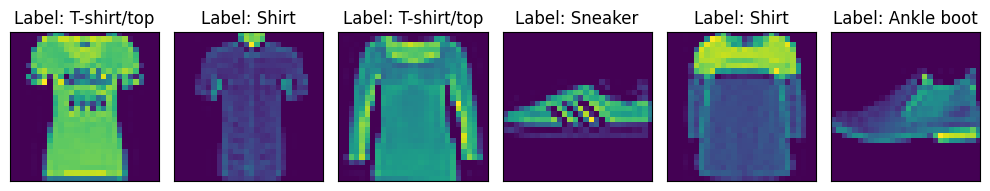

In [21]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

# Building Model Arcitechture

<h2>Implement the Convolutional Neural Network shown below:</h2>

<img src='https://drive.google.com/uc?id=1eN-rEyMCmApg7tASsmtkBQM7HbU1ZORH'>

In [86]:
from torch.nn import Conv2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import BatchNorm2d
from torch.nn import Dropout

class Simple_CNN(nn.Module):
  def __init__(self):
    super(Simple_CNN, self).__init__()
    """ Defining layers """
    self.conv1 = Sequential(
      Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
      BatchNorm2d(num_features=32),
      ReLU(),
      MaxPool2d(kernel_size=2, stride=2)
      )
    self.conv2 = Sequential(
      Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
      BatchNorm2d(num_features=64),
      ReLU(),
      MaxPool2d(kernel_size=2, stride=2)
    )
    self.linear = Sequential(
      Linear(in_features=2304, out_features=512, bias=True),
      Dropout(p=0.2, inplace=False),
      Linear(in_features=512, out_features=128, bias=True),
      Linear(in_features=128, out_features=10, bias=True),
    )


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)
    out=self.linear(x)
    return out


  def Fit(self, num_epochs, train_loader, val_loader, optimizer, criterion):
    train_losses = []
    val_losses = []
    train_accuracies=[]
    val_accuracies=[]

    for epoch in range(num_epochs):
      train_per_epoch_loss=0
      train_data_total = 0
      train_data_correct = 0

      ####### Training Phase ########
      self.train()
      with tqdm(train_loader, unit="batch") as batches:
        for images, labels in batches:
          images, labels = images.to(device), labels.to(device)
          batches.set_description(f"Epoch {epoch + 1}")
          
          output = self.forward(images)
          predictions = torch.argmax(output, dim=1)
          matches = torch.eq(predictions, labels)
          num_matches = torch.sum(matches).item()

          loss = criterion(output, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_data_correct += num_matches
          train_data_total += len(labels)
          train_per_epoch_loss += loss.item()
          batches.set_postfix(train_loss = (train_per_epoch_loss/len(train_loader)), train_accuracy = (train_data_correct * 100 / train_data_total)) # show loss and accuracy per batch of data


      train_accuracy = train_data_correct * 100 / train_data_total
      train_accuracies.append(train_accuracy)
      train_losses.append(train_per_epoch_loss/len(train_loader))


      ####### Validation Phase ########
      val_per_epoch_loss=0
      val_data_total = 0
      val_data_correct = 0

      self.eval()
      with torch.no_grad():
        for images, labels in val_loader:
          """ Implement Validation steps """
          images, labels = images.to(device), labels.to(device)
          
          output = self.forward(images)
          loss = criterion(output, labels)
          predictions = torch.argmax(output, dim=1)
          matches = torch.eq(predictions, labels)
          num_matches = torch.sum(matches).item()
          
          val_per_epoch_loss += loss.item()
          val_data_correct += num_matches
          val_data_total += len(labels)

      val_accuracy = val_data_correct * 100 / val_data_total
      val_losses.append(val_per_epoch_loss/len(val_loader))
      val_accuracies.append(val_accuracy)

      print(f"End of Epoch {epoch + 1}: Validation accuray: {val_accuracy}, Validation Loss: {val_per_epoch_loss/len(val_loader)}")
      print("-"*40)

    self.history={
      'train_losses':train_losses,
      'val_losses':val_losses,
      'train_accuracies':train_accuracies,
      'val_accuracies':val_accuracies
    }
    return self.history


In [87]:
model = Simple_CNN()
model.to(device)
print(model)

Simple_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


# Training the model

In [88]:
num_epochs = 30
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
history = model.Fit(num_epochs, train_dataloader, val_dataloader, optimizer, criterion)

Epoch 1: 100%|██████████| 844/844 [00:15<00:00, 54.21batch/s, train_accuracy=84.8, train_loss=0.432] 


End of Epoch 1: Validation accuray: 88.53333333333333, Validation Loss: 0.32763036451441174
----------------------------------------


Epoch 2: 100%|██████████| 844/844 [00:16<00:00, 52.67batch/s, train_accuracy=89.4, train_loss=0.296] 


End of Epoch 2: Validation accuray: 90.35, Validation Loss: 0.27065532931939085
----------------------------------------


Epoch 3: 100%|██████████| 844/844 [00:16<00:00, 50.46batch/s, train_accuracy=90.8, train_loss=0.255] 


End of Epoch 3: Validation accuray: 90.9, Validation Loss: 0.2616301434154206
----------------------------------------


Epoch 4: 100%|██████████| 844/844 [00:16<00:00, 51.71batch/s, train_accuracy=92, train_loss=0.228]   


End of Epoch 4: Validation accuray: 91.48333333333333, Validation Loss: 0.24313274889867356
----------------------------------------


Epoch 5: 100%|██████████| 844/844 [00:16<00:00, 51.78batch/s, train_accuracy=92.5, train_loss=0.208] 


End of Epoch 5: Validation accuray: 91.18333333333334, Validation Loss: 0.2457481449113247
----------------------------------------


Epoch 6: 100%|██████████| 844/844 [00:16<00:00, 50.77batch/s, train_accuracy=93.2, train_loss=0.191] 


End of Epoch 6: Validation accuray: 91.33333333333333, Validation Loss: 0.24157742549605826
----------------------------------------


Epoch 7: 100%|██████████| 844/844 [00:16<00:00, 51.44batch/s, train_accuracy=93.7, train_loss=0.174] 


End of Epoch 7: Validation accuray: 91.11666666666666, Validation Loss: 0.26995903895573414
----------------------------------------


Epoch 8: 100%|██████████| 844/844 [00:16<00:00, 51.81batch/s, train_accuracy=94.2, train_loss=0.163] 


End of Epoch 8: Validation accuray: 92.4, Validation Loss: 0.2251342724057588
----------------------------------------


Epoch 9: 100%|██████████| 844/844 [00:16<00:00, 51.47batch/s, train_accuracy=94.5, train_loss=0.151] 


End of Epoch 9: Validation accuray: 91.15, Validation Loss: 0.26616414541259725
----------------------------------------


Epoch 10: 100%|██████████| 844/844 [00:16<00:00, 51.58batch/s, train_accuracy=94.8, train_loss=0.142] 


End of Epoch 10: Validation accuray: 91.58333333333333, Validation Loss: 0.25609546297408164
----------------------------------------


Epoch 11: 100%|██████████| 844/844 [00:16<00:00, 51.36batch/s, train_accuracy=95.2, train_loss=0.131] 


End of Epoch 11: Validation accuray: 91.28333333333333, Validation Loss: 0.2804356978294697
----------------------------------------


Epoch 12: 100%|██████████| 844/844 [00:16<00:00, 51.26batch/s, train_accuracy=95.5, train_loss=0.124] 


End of Epoch 12: Validation accuray: 91.3, Validation Loss: 0.2907439200405745
----------------------------------------


Epoch 13: 100%|██████████| 844/844 [00:16<00:00, 51.49batch/s, train_accuracy=95.8, train_loss=0.116] 


End of Epoch 13: Validation accuray: 91.28333333333333, Validation Loss: 0.27898622977923837
----------------------------------------


Epoch 14: 100%|██████████| 844/844 [00:16<00:00, 51.41batch/s, train_accuracy=96, train_loss=0.108]    


End of Epoch 14: Validation accuray: 91.7, Validation Loss: 0.2890040128234219
----------------------------------------


Epoch 15: 100%|██████████| 844/844 [00:16<00:00, 51.28batch/s, train_accuracy=96.4, train_loss=0.102]  


End of Epoch 15: Validation accuray: 91.3, Validation Loss: 0.3239726720060757
----------------------------------------


Epoch 16: 100%|██████████| 844/844 [00:16<00:00, 51.47batch/s, train_accuracy=96.4, train_loss=0.0975] 


End of Epoch 16: Validation accuray: 90.8, Validation Loss: 0.3350812649909169
----------------------------------------


Epoch 17: 100%|██████████| 844/844 [00:16<00:00, 51.58batch/s, train_accuracy=96.7, train_loss=0.0892] 


End of Epoch 17: Validation accuray: 91.53333333333333, Validation Loss: 0.3057717363686955
----------------------------------------


Epoch 18: 100%|██████████| 844/844 [00:16<00:00, 51.36batch/s, train_accuracy=96.9, train_loss=0.0867] 


End of Epoch 18: Validation accuray: 91.26666666666667, Validation Loss: 0.35476720903782133
----------------------------------------


Epoch 19: 100%|██████████| 844/844 [00:16<00:00, 50.60batch/s, train_accuracy=96.9, train_loss=0.0842] 


End of Epoch 19: Validation accuray: 91.18333333333334, Validation Loss: 0.3593484827495636
----------------------------------------


Epoch 20: 100%|██████████| 844/844 [00:17<00:00, 48.01batch/s, train_accuracy=97.1, train_loss=0.0776] 


End of Epoch 20: Validation accuray: 90.63333333333334, Validation Loss: 0.37401295453310013
----------------------------------------


Epoch 21: 100%|██████████| 844/844 [00:17<00:00, 49.44batch/s, train_accuracy=97.3, train_loss=0.0719] 


End of Epoch 21: Validation accuray: 90.9, Validation Loss: 0.37863398295767764
----------------------------------------


Epoch 22: 100%|██████████| 844/844 [00:16<00:00, 50.55batch/s, train_accuracy=97.3, train_loss=0.0722] 


End of Epoch 22: Validation accuray: 91.13333333333334, Validation Loss: 0.35334376546930757
----------------------------------------


Epoch 23: 100%|██████████| 844/844 [00:16<00:00, 51.11batch/s, train_accuracy=97.7, train_loss=0.063]  


End of Epoch 23: Validation accuray: 91.26666666666667, Validation Loss: 0.3866214952629773
----------------------------------------


Epoch 24: 100%|██████████| 844/844 [00:16<00:00, 51.20batch/s, train_accuracy=97.7, train_loss=0.0656] 


End of Epoch 24: Validation accuray: 90.75, Validation Loss: 0.4545993997537075
----------------------------------------


Epoch 25: 100%|██████████| 844/844 [00:16<00:00, 51.42batch/s, train_accuracy=97.7, train_loss=0.0633] 


End of Epoch 25: Validation accuray: 90.98333333333333, Validation Loss: 0.4234613410415167
----------------------------------------


Epoch 26: 100%|██████████| 844/844 [00:16<00:00, 51.39batch/s, train_accuracy=97.8, train_loss=0.0619] 


End of Epoch 26: Validation accuray: 91.11666666666666, Validation Loss: 0.44861569204070467
----------------------------------------


Epoch 27: 100%|██████████| 844/844 [00:16<00:00, 51.42batch/s, train_accuracy=97.8, train_loss=0.0581] 


End of Epoch 27: Validation accuray: 91.56666666666666, Validation Loss: 0.4054488879331249
----------------------------------------


Epoch 28: 100%|██████████| 844/844 [00:16<00:00, 51.23batch/s, train_accuracy=98, train_loss=0.0551]   


End of Epoch 28: Validation accuray: 91.25, Validation Loss: 0.4518316513363351
----------------------------------------


Epoch 29: 100%|██████████| 844/844 [00:16<00:00, 51.45batch/s, train_accuracy=98.2, train_loss=0.0506] 


End of Epoch 29: Validation accuray: 91.18333333333334, Validation Loss: 0.4488159826426628
----------------------------------------


Epoch 30: 100%|██████████| 844/844 [00:16<00:00, 51.36batch/s, train_accuracy=98.1, train_loss=0.0518] 


End of Epoch 30: Validation accuray: 90.36666666666666, Validation Loss: 0.4829750270285505
----------------------------------------


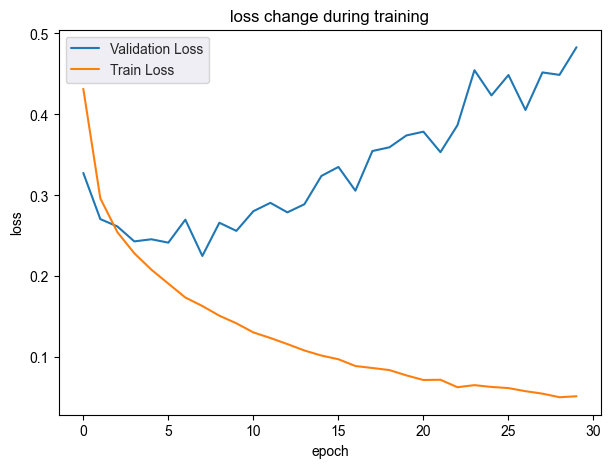

In [89]:
# plot losses
plt.subplots(figsize=(7, 5))
sns.set_style("dark")
sns.lineplot(data=history['val_losses'],label="Validation Loss")
sns.lineplot(data=np.asarray(history['train_losses']),label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

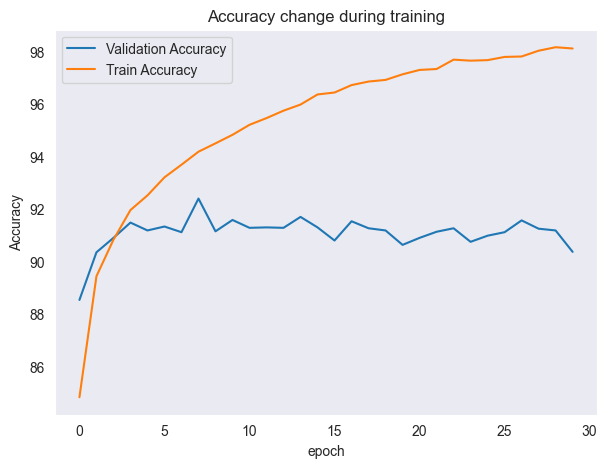

In [90]:
# plot Accuracy
plt.subplots(figsize=(7, 5))
sns.set_style("dark")
sns.lineplot(data=history['val_accuracies'],label="Validation Accuracy")
sns.lineplot(data=np.asarray(history['train_accuracies']),label="Train Accuracy").set(title="Accuracy change during training", xlabel="epoch", ylabel="Accuracy")
plt.legend()
plt.show()

# Prediction on Test Data

In [91]:
def predict(images, model):
  predicted = model(images)
  return predicted

**Accuracy Result on Test Data**

In [98]:
correct = 0
total = 0
y_pred_list = []
y_true_list = []
with torch.no_grad():
  for data in test_dataloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    output = predict(images, model)
    predicted = torch.argmax(output, dim=1)
    matches = torch.eq(predicted, labels)
    num_matches = torch.sum(matches).item()
    correct += num_matches
    total += len(predicted)
    for x in predicted.cpu().numpy(): y_pred_list.append(x)
    for x in labels.cpu().numpy(): y_true_list.append(x)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


**Classification report**

In [99]:
print(classification_report(y_true_list, y_pred_list, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.83      0.84      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.91      0.77      0.83      1000
       Dress       0.93      0.88      0.91      1000
        Coat       0.78      0.91      0.84      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.70      0.75      0.73      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



<Axes: >

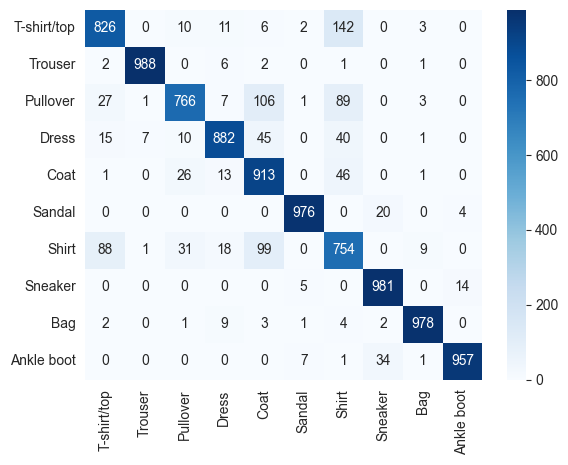

In [100]:
cf_matrix = confusion_matrix(y_true_list, y_pred_list)
sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, annot=True, cmap='Blues', fmt='g')

**Displaying a random set of images from test data**

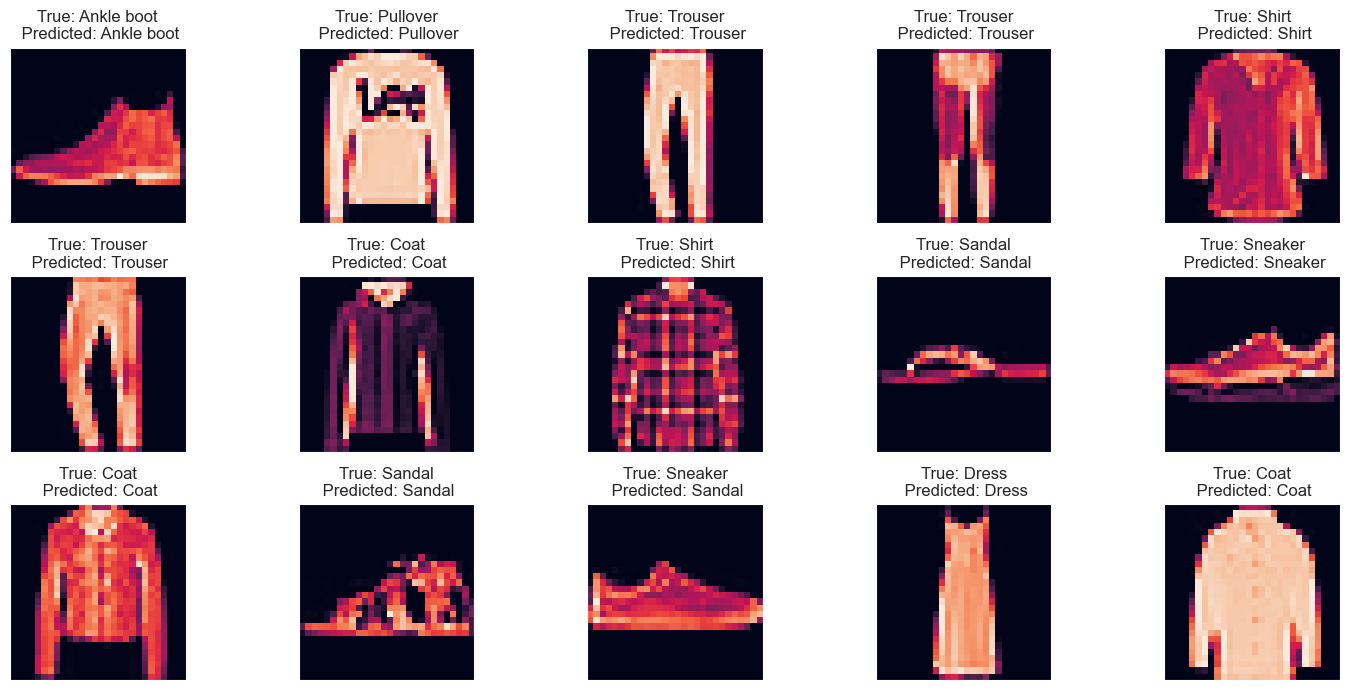

In [108]:
model = model.cpu()
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images, model)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,16),axes.flat):
    img,label=images[i],labels[i]
    pred=torch.argmax(predicted[i])
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {classes[label.item()]}\n Predicted: {classes[pred.item()]}")

plt.tight_layout()
plt.show()